D
R


11

In [97]:
import os
import pandas as pd 
 
path = '/Users/michael/Google Drive/NYC-DAT-34/projects/michael_donnelly/proj2/'

In [78]:
from sunlightapi import sunlight, SunlightApiError
sunlight.apikey = '0806e9fd3fb648ce87b474dd666709df'

In [150]:
%%time
rawcat = pd.DataFrame()
for x in ('D', 'R'):
    sunurl = 'http://capitolwords.org/api/1/text.json?congress=111&chamber=house&party='+x+'&apikey=0806e9fd3fb648ce87b474dd666709df'
    sunraw = pd.read_json(path_or_buf=sunurl, orient='values')
    if sunraw.num_found[1]%50>0: 
        pagerange = (sunraw.num_found[1]/50)+1
    else:
        pagerange = (sunraw.num_found[1]/50)
    print pagerange
    for page in range(1,pagerange+1):
        sunurl = 'http://capitolwords.org/api/1/text.json?congress=111&chamber=house&party='+x \
        +'&per_page=50&page='+str(page)+'&apikey='+sunlight.apikey
        rawcat = pd.concat([pd.read_json(path_or_buf=sunurl, orient='values'), rawcat])

689
593


In [151]:
df = pd.concat([pd.DataFrame.from_dict(item, orient='index').T for item in rawcat.results])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63941 entries, 0 to 0
Data columns (total 20 columns):
speaker_state       63941 non-null object
speaker_raw         63941 non-null object
speaker_first       63941 non-null object
congress            63941 non-null object
title               63941 non-null object
origin_url          63941 non-null object
number              63941 non-null object
id                  63941 non-null object
volume              63941 non-null object
chamber             63941 non-null object
session             63941 non-null object
speaker_last        63941 non-null object
pages               63941 non-null object
speaker_party       63941 non-null object
date                63941 non-null object
bills               8203 non-null object
bioguide_id         63941 non-null object
order               63941 non-null object
speaking            63941 non-null object
capitolwords_url    63941 non-null object
dtypes: object(20)
memory usage: 10.2+ MB


In [153]:
df.to_csv(path+'111.csv', encoding='utf-8')

In [157]:
df[1100:1103]

,speaker_state,speaker_raw,speaker_first,congress,title,origin_url,number,id,volume,chamber,session,speaker_last,pages,speaker_party,date,bills,bioguide_id,order,speaking,capitolwords_url
0,AL,mr. bachus,Spencer,111,PAY FOR PERFORMANCE ACT,http://origin.www.gpo.gov/fdsys/pkg/CREC-2009-...,55,CREC-2009-04-01-pt1-PgH4287-2.chunk154,155,House,1,Bachus,H4287-H4310,R,2009-04-01,None,B000013,154,"[Mr. Chairman, the gentleman who offered this ...",http://capitolwords.org/date/2009/04/01/H4287-...
0,GA,mr. price of georgia,Tom,111,PAY FOR PERFORMANCE ACT,http://origin.www.gpo.gov/fdsys/pkg/CREC-2009-...,55,CREC-2009-04-01-pt1-PgH4287-2.chunk162,155,House,1,Price,H4287-H4310,R,2009-04-01,None,P000591,162,"[Mr. Chairman, I understand I have 30 seconds....",http://capitolwords.org/date/2009/04/01/H4287-...
0,GA,mr. price of georgia,Tom,111,PAY FOR PERFORMANCE ACT,http://origin.www.gpo.gov/fdsys/pkg/CREC-2009-...,55,CREC-2009-04-01-pt1-PgH4287-2.chunk163,155,House,1,Price,H4287-H4310,R,2009-04-01,None,P000591,163,[I am pleased to yield my 30 seconds to the ch...,http://capitolwords.org/date/2009/04/01/H4287-...


In [160]:
df.drop(df.columns[['speaker_raw']], axis=1, inplace=True)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
words = pd.Series([word for line in df.speech.values for word in line.lower().split()]).value_counts()
words.head(20)

the     89378
,       74868
.       62787
to      47780
of      42010
and     37862
that    27773
in      26691
a       23264
is      20759
i       20021
this    18897
for     16118
we      16039
it      13014
not     11368
are     10933
have    10915
on      10789
mr.     10244
dtype: int64

In [7]:
df['dem'] = 0
df.ix[df.partyID=="D", 'dem'] = 1

In [12]:
#%%time
from sklearn.feature_extraction import text
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import SelectPercentile, f_classif
#cross_val_score
#cv = CountVectorizer(stop_words = 'english', ngram_range=(1,4), max_features=2000, 
#                     min_df=.10, # only use words that appear at least some times (integer = absolute count)
#                     max_df=.95)  # ignore words that appear too frequently

cv = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3), 
                     min_df=.05, # only use words that appear at least some times (integer = absolute count)
                     max_df=.5)  # ignore words that appear too frequently

X, y = cv.fit_transform(df.speech).todense(), df.dem

#selector = SelectPercentile(f_classif, percentile=10)

In [13]:
for n in xrange(-3, 5):
    alpha = 10 ** n
    print "alpha %10.4f  OLS %.4f Lasso %.4f Ridge %.4f" % \
        (alpha, 
         -cross_val_score(LogisticRegression(C=10, penalty='l1'), X, y, cv=10, scoring='mean_absolute_error').mean(),
         -cross_val_score(Lasso(alpha), X, y, cv=10, scoring='mean_absolute_error').mean(), 
         -cross_val_score(Ridge(alpha), X, y, cv=10, scoring='mean_absolute_error').mean())

alpha     0.0010  OLS 0.3705 Lasso 0.4721 Ridge 0.4356
alpha     0.0100  OLS 0.3705 Lasso 0.5004 Ridge 0.4356
alpha     0.1000  OLS 0.3705 Lasso 0.5004 Ridge 0.4357
alpha     1.0000  OLS 0.3705 Lasso 0.5004 Ridge 0.4367
alpha    10.0000  OLS 0.3705 Lasso 0.5004 Ridge 0.4514
alpha   100.0000  OLS 0.3705 Lasso 0.5004 Ridge 0.4843
alpha  1000.0000  OLS 0.3705 Lasso 0.5004 Ridge 0.4978
alpha 10000.0000  OLS 0.3705 Lasso 0.5004 Ridge 0.5001


In [15]:
import numpy as np
for score in range(2):
    print "Always %d gives MAE %.4f" % (score, np.abs(score - df.dem).mean())

Always 0 gives MAE 0.5032
Always 1 gives MAE 0.4968


Worst: balance time, consume, chairman, point, gentleman, good, united states, important, act, minutes, government, work, percent, speaker, issue
Best : colleagues, national, does, president, people, know, country, california, provide, mr, member, vote, yield minutes, thank gentleman, fact


/Users/michael/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: sort is deprecated, use sort_values(inplace=True) for for INPLACE sorting


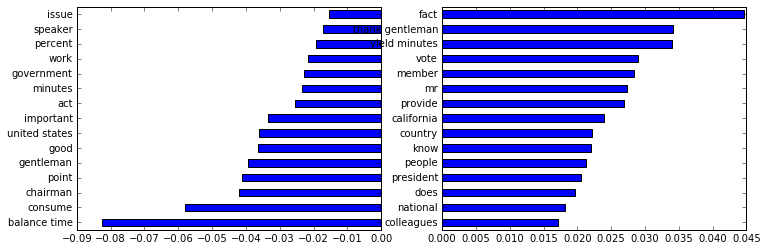

In [78]:
from matplotlib import pyplot as plt
%matplotlib inline


model = Ridge(alpha=100)
model.fit(X, y)

coef = pd.Series(model.coef_, index=cv.get_feature_names())
coef.sort()
top = 15
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
f = coef[:top].plot(kind='barh', ax=axes[0])
f = coef[-top:].plot(kind='barh', ax=axes[1])
print "Worst:", ", ".join(coef[:top].index)
print "Best :", ", ".join(coef[-top:].index)

In [ ]:
from sklearn.cross_validation import KFold

model = Lasso(alpha=.001)
#model = LinearRegression()
#model = Ridge(alpha=100)

kfold = KFold(len(X), n_folds=5, shuffle=True)
np.mean(cross_val_score(model, X, y, cv=kfold, scoring='r2'))